### Importing Libraries

In [0]:
import urllib 
import urllib.request

import pandas as pd
import os as os
import gzip
import sys

import re
import warnings
warnings.filterwarnings("ignore")
import string

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch


pd.set_option('display.max_colwidth', -1)

### Read the input CSV File and store in a dataframe

In [0]:
# inputTupleSize = sys.argv[1]
# inputFile = sys.argv[2]

inputFile = "https://www.eecs.uottawa.ca/~turcotte/teaching/csi-5180/assignments/1/human_skin_microbiome.csv"
inputTupleSize = 6

# Read the input CSV File and store in a dataframe
inputDataframe = pd.read_csv(inputFile)
inputDataframe['FileName'] = inputDataframe['Organism'].str.replace(" ", "_") + '.fa.gz'

### Creating the target directory for dataset

In [0]:
def createDirectoryForDataset():
  print('--------------------------------------------------------------------------------------------------')
  print('Creating the target directory for dataset')
  if not os.path.exists('GenomeFiles'):
    os.mkdir('GenomeFiles')
    print('Target directory for dataset: GenomeFiles')
  else:
    print('Target directory already exist!')
  print('==================================================================================================')

### Downloading the dataset (*if it does not exist*)

In [0]:
# Downloading the fasta files for each organism


def downloadDataset(inputDataframe):
  print('Download and Cleaning of dataset started')
  print('--------------------------------------------------------------------------------------------------')
  for index, row in inputDataframe.iterrows():

    fileName = 'GenomeFiles/' + row['FileName']
    preprocessedFileName = 'GenomeFiles/' + row['FileName'].replace('fa.gz', 'txt')

    if not os.path.exists(preprocessedFileName):
      print('Downloading ' + row['FileName'])
      # Downloading .fa.gz file
      #urllib.urlretrieve(row['URL'], fileName)
      urllib.request.urlretrieve(row['URL'], fileName)
      # Reading the downloaded file
      preprocessedFile = open(preprocessedFileName, "w") 

      print('Cleaning ' + row['FileName'])

      for line in gzip.open(fileName, "r"): 
        if line.startswith(b'>'): 
            preprocessedFile.write('\n') 
        else:
          preprocessedFile.write((line.decode()).replace('\n',''))
      preprocessedFile.close() 
    else:
        print(row['FileName'] + ' already exists!')
  print('--------------------------------------------------------------------------------------------------')
  print('Download and Cleaning of dataset completed')
  print('==================================================================================================')

### Generating pairs from sequence

In [0]:
def getpairs(sequence, size):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]


### Preprocessing dataset

In [0]:
def preprocessDataset(inputDataframe):
  print('Preprocessing (generating pairs) of dataset started')
  print('--------------------------------------------------------------------------------------------------')

  # Creating a new dataframe to hold the preprocessed results
  df = pd.DataFrame()
  df = df.append(inputDataframe)
  df['Sentence'] = ''
  df['Pairs'] = 0

  # Iterating over each organisms one by one ...
  for index, row in inputDataframe.iterrows():
    print('Preprocessing ' + row['FileName'])

    fileName = 'GenomeFiles/' + row['FileName']
    preprocessedFileName = 'GenomeFiles/' + row['FileName'].replace('fa.gz', 'txt')

    # Holds all the sequences for the organism 
    preprocessedFileDf = pd.read_csv(preprocessedFileName, header=None)

    # Iterate over the preprocessed dataframe
    finalSentence = ''
    numberOfPairs = 0
    for innerIndex, row in preprocessedFileDf.iterrows():
      sequence = row[0].lower()
      for letter in list(string.ascii_lowercase):
        if letter in ['a', 'c', 'g', 't']:
          continue
        else:
          sequence = sequence.replace(letter,'')

      sequence = sequence.replace(' ','')
      words = getpairs(sequence, size=int(inputTupleSize))
      numberOfPairs = numberOfPairs + len(words)
      sentence = ' '.join(words)
      if len(finalSentence) != 0:
        finalSentence = finalSentence + ' ' + sentence
      else:
        finalSentence = sentence
  #   w = finalSentence.split()  
  #   print(len(w), numberOfPairs, len(set(w)))
    df['Sentence'][index] = finalSentence
    df['Pairs'][index] = numberOfPairs
    
  #  print('Number of pairs', numberOfPairs)
    
  print('--------------------------------------------------------------------------------------------------')
  print('Preprocessing of dataset completed')
  print('==================================================================================================')
  return df


### Generating frequency vectors

In [0]:
def getFrequencyVectors(df):
  print('Generating frequency vectors')
  print('--------------------------------------------------------------------------------------------------')
  cv = CountVectorizer()
  X = cv.fit_transform(df['Sentence'].values).toarray()
  
  X = X.astype(float)
  
  for index, row in df.iterrows():
    X[index] = X[index] / df['Pairs'][index]
  
  print('Frequency vector :', X)
  print('Generating Frequency vectors completed, size: '+  str(X.shape))
  
  print('==================================================================================================')
  
  return X

### Applying KMeans

In [0]:
def kMeansModel(X):
  print('Applying KMeans with cluster range as 2 to ' + str(X.shape[0]))
  inertia = []
  sil = []
  K = range(2,X.shape[0])
  for k in K:
      print('Running number of cluster: ' + str(k))
      km = KMeans(n_clusters=k)
      km = km.fit(X)
      inertia.append(km.inertia_)
      labels = km.labels_
      sil.append(silhouette_score(X, labels, metric = 'euclidean'))
  return K, inertia, sil

### Plotting Interia

In [0]:
def plotInertia(K, inertia):

  fig, ax = plt.subplots(1, figsize=(15, 6))
  fig.suptitle('Inertia of the Clusters')
  plt.xlabel('Number of Clusters')
  plt.ylabel('Inertia')

  # Plot the data
  ax.plot(K, inertia)
  plt.xticks(range(min(K), max(K), 1))

  # Show the grid lines as dark grey lines
  plt.grid(b=True, which='major', color='#666666', linestyle='-')
  plt.savefig('Inertia.png')
  return plt.show()

### Plotting silhouette score

In [0]:
def plotSilhouette(K, sil):

  fig, ax = plt.subplots(1, figsize=(15, 6))
  fig.suptitle('Silhouette Score of the Clusters')
  plt.xlabel('Number of Clusters')
  plt.ylabel('Silhouette Score')

  # Plot the data
  ax.plot(K, sil)
  plt.xticks(range(min(K), max(K)+1, 1))

  # Show the grid lines as dark grey lines
  plt.grid(b=True, which='major', color='#666666', linestyle='-')
  plt.savefig('SilhouetteScore.png')
  
  print('Based on the plot, the optimal number of clusters are ', str(sil.index(max(sil)) + 2))
  
  return plt.show()

### Plotting Dendrorgram

In [0]:
def plotDendrogram(X, label, methodName):

  fig, ax = plt.subplots(1, figsize=(12, 8))
  fig.suptitle('Dendrogram')
  plt.xlabel('Species')
  plt.ylabel('Euclidean Distance')
  
  dendrogram = sch.dendrogram(sch.linkage(X, method=methodName), leaf_rotation=90, leaf_font_size=14, labels=label)

  plt.savefig('Dendrogram.png')
  return plt.show()


### Pipeline

--------------------------------------------------------------------------------------------------
Creating the target directory for dataset
Target directory already exist!
Download and Cleaning of dataset started
--------------------------------------------------------------------------------------------------
Acinetobacter_ursingii.fa.gz already exists!
Bacillus_cereus.fa.gz already exists!
Candida_albicans.fa.gz already exists!
Corynebacterium_accolens.fa.gz already exists!
Corynebacterium_diphtheriae.fa.gz already exists!
Corynebacterium_glucuronolyticum.fa.gz already exists!
Corynebacterium_pseudotuberculosis.fa.gz already exists!
Corynebacterium_striatum.fa.gz already exists!
Cutibacterium_acnes.fa.gz already exists!
Enterobacter_cloacae.fa.gz already exists!
Kytococcus_sedentarius.fa.gz already exists!
Malassezia_restricta.fa.gz already exists!
Micrococcus_luteus.fa.gz already exists!
Mycobacterium_avium.fa.gz already exists!
Mycobacterium_marinum.fa.gz already exists!
Mycobacte

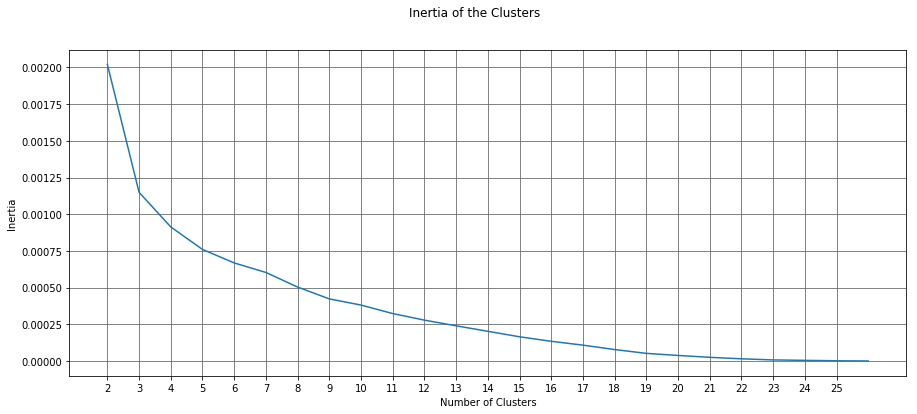

Based on the plot, the optimal number of clusters are  2


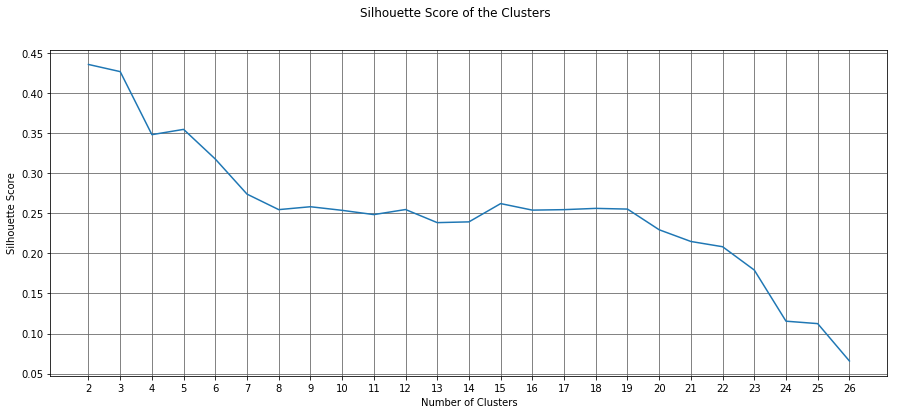

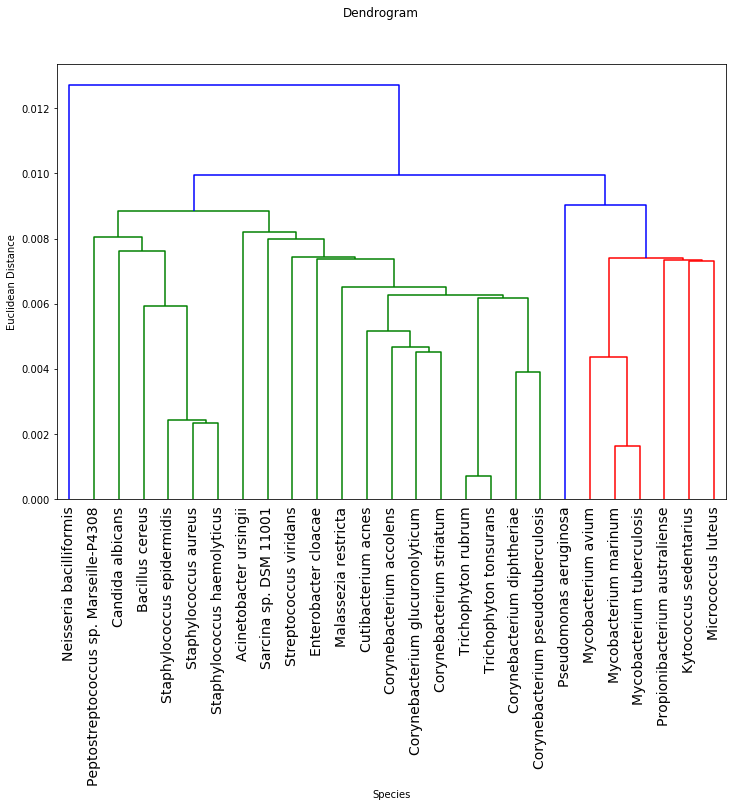

In [0]:
# Step 1: Create Directory for the dataset
createDirectoryForDataset()

# Step 2: Download the dataset (if it does not exists)
downloadDataset(inputDataframe)

# Step 3: Preprocess the dataset
df = preprocessDataset(inputDataframe)

# Step 4: Generate frequency vectors
X = getFrequencyVectors(df)

# Step 5: Apply KMeans
K, inertia, sil = kMeansModel(X)

# Step 6: Plot Inertia
plotInertia(K, inertia)

# Step 7: Plot Silhouette Score
plotSilhouette(K, sil)

# Step 8: Dendrogram and Linkage
plotDendrogram(X, inputDataframe.Organism.values, 'single')

# Using Ward Method
# plotDendrogram(X, inputDataframe.Organism.values, 'ward')

# Using Average Method
# plotDendrogram(X, inputDataframe.Organism.values, 'average')